## Calculating the root zone fractions in each layer for CONUS2.0 

- Calculate the fraction of the roots in every vertical layer of a PF-CLM model. This is a necessary input for evaptrans calcs
- Notes on evaptrans calcs from reed [here](https://docs.google.com/document/d/1TNZCPCYj1qsA4OlMlN3NB6XSOuV5fUmY4w4f6O7dm_8/edit?pli=1&tab=t.0)
- This script requries a `land_cover_params.csv` file which has the roota and rootb parameters for every landcover type
- It produces: 
     1. `root_zone_fractions.csv` which has the root zone fractions in every clm connected layer for every land cover type
     2. Four pfb files `root_zone_frac_layer{x}.pfb` which are 2D pfb files with the root zone fraction in each layer of clm coulpled layers These are created by combining the root fracs with the landcover map


### Root zone fraction calculations from clm:
Rooting fractions are calculated as follows from pfsimulator/clm/drv_clmini.F90. See Reed's excel calculations [here](https://docs.google.com/spreadsheets/d/1upoZ9YMKSI5ltebsOxCjXSj8dNW4xdrNl5MDPWAKaKg/edit?gid=0#gid=0) for reference

```
do j = 1, nlevsoi-1
     clm%rootfr(j) = .5*( exp(-tile%roota*clm%zi(j-1))  &
                        + exp(-tile%rootb*clm%zi(j-1))  &
  enddo
  clm%rootfr(nlevsoi)=.5*( exp(-tile%roota*clm%zi(nlevsoi-1))&
                         + exp(-tile%rootb*clm%zi(nlevsoi-1)))

Where the interface depths Zi are
clm%zi(0)   = 0.                             !interface depths 
     do j = 1, nlevsoi-1
        clm%zi(j)= 0.5*(clm%z(j)+clm%z(j+1))     
     enddo
     clm%zi(nlevsoi) = clm%z(nlevsoi) + 0.5*clm%dz(nlevsoi) 
```

### Preliminary setup

In [22]:
import pandas as pd
import os 
import numpy as np
import hf_hydrodata as hf
from parflow.tools.io import write_pfb
import matplotlib.pyplot as plt

In [ ]:
# You need to register on https://hydrogen.princeton.edu/pin before you can use the hydrodata utilities
email = input('Enter your hydrogen email address')
pin = input('Enter your hydrogen PIN')
print('Registering ' + email + ' (PIN=' + pin + ') for HydroData download' ) 
hf.register_api_pin(email, pin)

Registering lecondon@email.arizona.edu (PIN=1234) for HydroData download


In [24]:
# Setting directories
#Directory where the root zoon params will be read and written to
param_dir='/Users/laura/Documents/Research/NAIRR/hydrogen-emulator-1ts/notebooks'

#DZ list for CONUS2
dz_list = [0.1, 0.3, 0.6, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0, 200.0]

#number of layers the root zone is distributed over in PF-CLM coupling
nroot_lay = 4 

## Calculate the root zone fractions in the CLM connected layers for every land cover type

Use the a and b parameters for each land cover type to calculate the fraction of roots in each layer of the ParFlow model that is connected to CLM

Results are saved in a csv `root_zone_fractions.csv`

In [25]:
# Read in the root zone parameters by land cover type
rz_param = pd.read_csv(os.path.join(param_dir, 'land_cover_params.csv'), index_col='Land Cover Type')
top_depth = np.append(0, np.cumsum(dz_list)) #Top depth of each layer
nz=len(dz_list)


# Function to calculate the root zone fraction in any layer given the a and b parameters and the top and bottom depth of the layer
def calc_root_frac(row, top_depth, bottom_depth):
    #return row['roota']+row['rootb']
    return 0.5*(np.exp(-top_depth*row['roota'])+np.exp(-top_depth*row['rootb'])-np.exp(-bottom_depth*row['roota'])-np.exp(-bottom_depth*row['rootb']))

# Loop over the number of root layers calculate the root zone fraction for every land cover type and add to the dataframe
for layer in range(nroot_lay):
    laytop = top_depth[layer] #layer top (depth below surface)
    laybot = top_depth[(layer+1)] #Layer bottom (depth below surface)
    print('Calculating fractions for layer', layer, ":", laytop, '-', laybot)
    col_name=f'rfrac_layer{layer}'
    rz_param[col_name] = rz_param.apply(lambda x: calc_root_frac(x,laytop,laybot), axis=1)

#Write out a new dataframe with this information
fout=os.path.join(param_dir, 'root_zone_fractions.csv')
rz_param.to_csv(fout)

Calculating fractions for layer 0 : 0.0 - 0.1
Calculating fractions for layer 1 : 0.1 - 0.4
Calculating fractions for layer 2 : 0.4 - 1.0
Calculating fractions for layer 3 : 1.0 - 2.0


## Write out pfbs with root zone fractions for each layer based on the CONUS2 landcover map

This uses the root zone fractions calculated above and the CONUS2.0 landcover dataset to create a pfb for each PF-CLM coupled layer that has the root fraction every cell. 

Cells outside the mask are given root fractions of 0 for all layers

### Read in Landcover, mask and top patches for CONUS2

In [26]:
# Read in the land cover classifications
options = {
      "dataset":"conus2_domain", "grid": "conus2", "variable": "veg_type_IGBP"
}
landcover=hf.get_gridded_data(options)
landcover=landcover[0,:,:] # make it a 2D array

#Read in the mask
options = {
      "dataset":"conus2_domain", "grid": "conus2", "variable": "mask"
}
mask=hf.get_gridded_data(options)

#Read the top patch data
options = {
      "dataset":"conus2_domain", "grid": "conus2", "variable": "top_patch"
}
top_patch=hf.get_gridded_data(options)

#print(landcover.shape)
#print(np.max(landcover))
#print(np.min(landcover))
#print(np.sum(mask))

### Create an array of root fractions for each layer and write out as pfb

In [27]:
# Write create an array and write out a pfb with the root fraction for layers 1:4 
for layer in range(nroot_lay):
    root_frac=np.copy(mask).astype(np.float64)
    col_name=f'rfrac_layer{layer}'
    print('layer', layer)
    for lc in np.arange(1,19):
        temp_frac = rz_param.loc[lc, col_name] #read the root zone frac for the given land cover type and layer
        root_frac[landcover==lc] = root_frac[landcover==lc] * temp_frac

    fout=os.path.join(param_dir, f'root_zone_frac_layer{layer}_{top_depth[layer]}-{top_depth[layer+1]}.pfb')
    write_pfb(fout, root_frac, dist=False)


layer 0
layer 1
layer 2
layer 3


### Some checking to be sure it makes sense

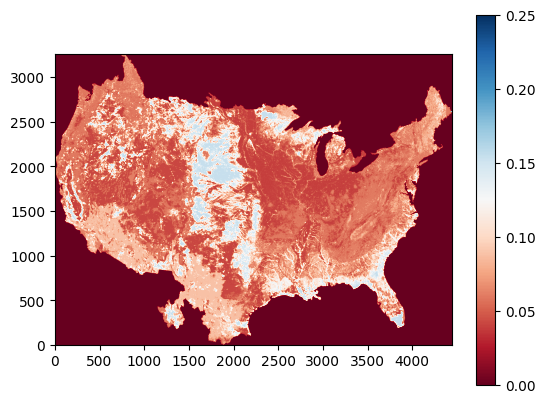

1.0
60
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Cells where root fraction is zero and mask is 1: (array([], dtype=int64), array([], dtype=int64))


In [29]:
str= plt.imshow(root_frac, cmap = "RdBu", origin='lower')
str.set_clim(vmin=0, vmax=0.25)
plt.colorbar(str, ax=plt.gca())
plt.show()

#There are 60 locations where the root fraction is equal to 1
# These all correspond to places where the landcover type is 0 and the mask is 1 and the top patch = 2 
# And they don't seem to correspond to lakes or sinks 
# From the CONUS2 run script: CONUS2.Geom.domain.Patches = "ocean land top lake sink bottom" 
# I think this means 2= top  
print(np.max(root_frac))
print(np.count_nonzero(root_frac == 1))
print(landcover[root_frac==1]) #where are these 60 cells is this just a missmatch of the landcover and the mask? 
print(mask[root_frac==1])
print(top_patch[root_frac==1])

# Check for locations where the root fraction is zero and the mask is 1
zero_root_frac_cells = np.where((root_frac == 0) & (mask == 1))
print("Cells where root fraction is zero and mask is 1:", zero_root_frac_cells)